In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras import layers
from tensorflow.keras import utils
print(tf.__version__)
import os

2.3.0-dev20200529


--------------
# Make a simple CNN with only Sentinel 1 images


This notebook continues where the notebook create_dataset left off.

Here, the dataset made at the end of the create_dataset notebook will be used to make a simpe network.

The aim up the project is to end up with an ensemble CNN model consisting of two CNNs. One for S1, and one for S3. 
For this reasion, the S1 and S3 will be examined individually.

In this notebookk, a SIMPLE CNN consisting only of Sentinel 1 images will be made.

The notebook intended to act as proof of concept on using the sentinel 1 images in CNN. It is not necessarly intended to have a high accuracy.


---------------------

Again, making the dataset as described ealier

In [93]:
data = 'C:\\Users\\krist\\Documents\\Syntese\\data\\NN_test\\sentinel1'
#checking that there are the two classes...
print(os.listdir(data))
# Create a dataset.
dataset_validation = keras.preprocessing.image_dataset_from_directory(data,labels='inferred',label_mode='binary', image_size=(500,500),color_mode='grayscale',seed=1,subset='validation',class_names=['fire','no_fire'],validation_split=0.1)
dataset_training = keras.preprocessing.image_dataset_from_directory(data,labels='inferred',label_mode='binary', image_size=(500,500),color_mode='grayscale',seed=1,subset='training',class_names=['fire','no_fire'],validation_split=0.1)

for data, labels in dataset_training:
    print(data.shape)  # (64, 200, 200, 3)
    print(labels.shape)  # (64,)

['fire', 'no_fire']
Found 28 files belonging to 2 classes.
Using 2 files for validation.
Found 28 files belonging to 2 classes.
Using 26 files for training.
(26, 500, 500, 1)
(26, 1)


-----------

### Illustrating the images

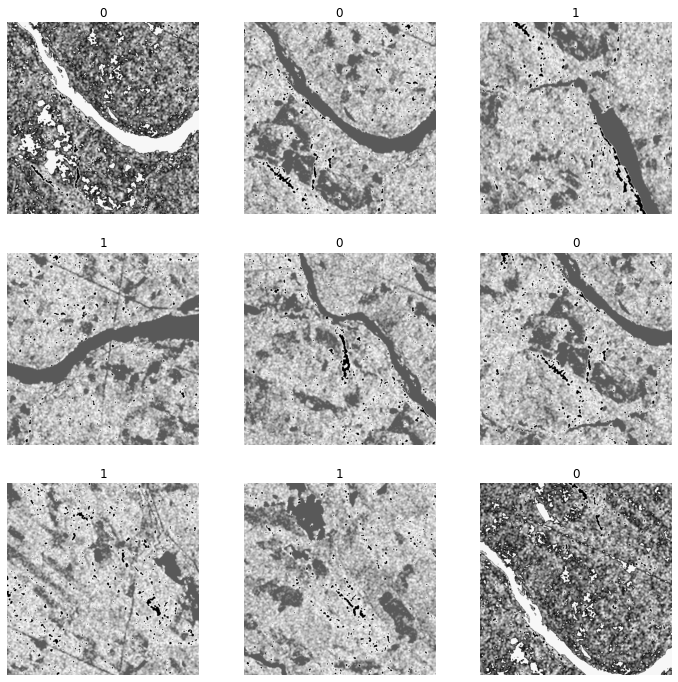

In [144]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(12, 12))
for images, labels in dataset_training.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.squeeze(images[i]),cmap='binary')
        plt.title(int(labels[i]))
        plt.axis('off')

In the 

--------------------

## Data augmentation

Now, there is only a limited dataset. Hence, data augmentation will be used, as expleined in the report.

In [147]:
dataset_augmentation = keras.Sequential([
  keras.layers.experimental.preprocessing.RandomFlip('horizontal')
])

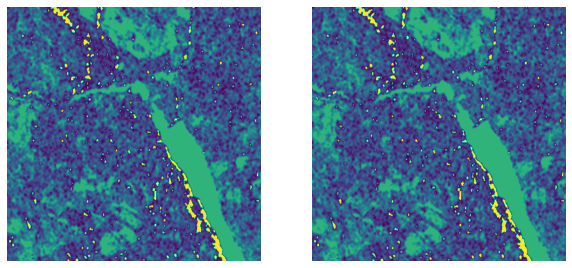

In [148]:
plt.figure(figsize=(10, 10))

for images, _ in dataset_training.take(1):
    for i in range(2):
        augmented_images = dataset_augmentation(images)
        ax = plt.subplot(1, 2, i + 1)
        plt.imshow(np.squeeze(augmented_images[0]).astype('uint8'))
        plt.axis('off')

It is computationally hard  to make CNN.. In order to make it easier, we prefetch the data so we avoid blocking (not important, just for computation)

In [121]:
dataset_training = dataset_training.prefetch(buffer_size=32)
dataset_validation = dataset_validation.prefetch(buffer_size=32)

--------------

### Building the model

Recall that sentinel-1 images have a size of 500x500 pixels and sentinel-3 images have different size. The important thing to notice is thus that the image size should be a parameter.

In [128]:
import pydot
import graphviz 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, save_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras import regularizers


In [126]:
def make_model(input_shape, num_classes):
  inputs = keras.Input(shape=input_shape)
  # Image augmentation block
  x = dataset_augmentation(inputs)

  # Entry block
  x = layers.experimental.preprocessing.Rescaling(1./255)(x)
  x = layers.Conv2D(32, 3, strides=2, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(64, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  previous_block_activation = x  # Set aside residual
  
  for size in [128, 256, 512, 728]:
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
    # Project residual
    residual = layers.Conv2D(
        size, 1, strides=2, padding='same')(previous_block_activation)
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

  x = layers.SeparableConv2D(1024, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  
  x = layers.GlobalAveragePooling2D()(x)
  if num_classes == 2:
    activation = 'sigmoid'
    units = 1
  else:
    activation = 'softmax'
    units = num_classes
  
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(units, activation=activation)(x)
  return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (1,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [151]:
epochs = 5

optimizer = keras.optimizers.SGD(lr=0.005)



callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
historie = model.fit(
    dataset_training, epochs=epochs, callbacks=callbacks, validation_data=dataset_validation,
)

Epoch 1/5
1/1 [==============================] - 3s 3s/step - loss: 0.5202 - accuracy: 0.6538 - val_loss: 1.9360 - val_accuracy: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 1s 871ms/step - loss: 0.6681 - accuracy: 0.6538 - val_loss: 1.9662 - val_accuracy: 0.0000e+00
Epoch 3/5
1/1 [==============================] - 1s 733ms/step - loss: 0.5148 - accuracy: 0.6538 - val_loss: 1.9945 - val_accuracy: 0.0000e+00
Epoch 4/5
1/1 [==============================] - 1s 913ms/step - loss: 0.4629 - accuracy: 0.6923 - val_loss: 2.0242 - val_accuracy: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 1s 734ms/step - loss: 0.5208 - accuracy: 0.6538 - val_loss: 2.0672 - val_accuracy: 0.0000e+00


------------------- 
Now the network has been trained.  It is thus possible to use the network to predict a fire.

(below is just a proof of concept)

In [152]:
img = keras.preprocessing.image.load_img('C:\\Users\\krist\\Documents\\Syntese\\data\\NN_test\\sentinel1\\fire\\fire_7_Subset_S1A_IW_GRDH_1SDV_20180723T051419_20180723T051444_022917_027C74_673F_NR_Cal_Spk_dB.tif_band2.png', target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
#img_array = tf.expand_dims(img_array, 1)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print('This image is %.2f fire and %.2f no_fire.' % (score, 1 - score))

This image is 0.86 fire and 0.14 no_fire.


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


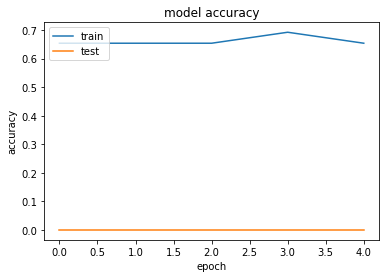

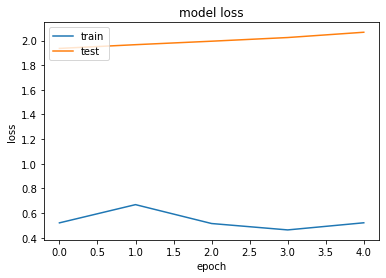

In [154]:
print(historie.history.keys())
# summarize history for accuracy
plt.plot(historie.history['accuracy'])
plt.plot(historie.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(historie.history['loss'])
plt.plot(historie.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()